In [427]:
import re

In [10]:
import numpy as np
import pandas as pd

In [11]:
from Bio import SeqIO
import os

In [12]:
from tqdm import tqdm

In [13]:
import json

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

In [15]:
import matplotlib.pyplot as plt

In [16]:
from sklearn.metrics import roc_curve, auc 

In [64]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

In [65]:
import random
from phylodm import PhyloDM
import dendropy

In [66]:
import seaborn as sns
from scipy import stats

In [372]:
co_embedding = pd.read_csv("/home/dongbiao/word_embedding_microbiome/all_data/gut/glove/abundance-percentile_100.txt",
                          header=None, sep=" ", low_memory=False, index_col=0)
co_embedding = co_embedding.drop("<unk>")

embed_cos = cosine_similarity(co_embedding)
embed_cos = pd.DataFrame(data=embed_cos, index=co_embedding.index, columns=co_embedding.index)

phy_embedding = pd.read_csv("/home/dongbiao/word_embedding_microbiome/all_data/gut/Phy_embedding/PCA/PCA_100.txt",
                          header=None, sep=" ", low_memory=False, index_col=0)
phy_embedding = phy_embedding.loc[co_embedding.index]

embed_cos_phy = cosine_similarity(phy_embedding)
embed_cos_phy = pd.DataFrame(data=embed_cos_phy, index=phy_embedding.index, columns=phy_embedding.index)

In [62]:
from scipy.stats import entropy

### vsearch

In [261]:
from Bio import SeqIO

def get_sequence_lengths(fasta_file):
    seq_lengths = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        seq_lengths[record.id] = len(record.seq)  # 存储序列ID和长度
    return seq_lengths

# 示例调用
fasta_path = "/home/dongbiao/word_embedding_microbiome/programe_test/phylogeny/data/feces_seq_16S_new.fasta"
length_dict = get_sequence_lengths(fasta_path)

In [251]:
colnames = ["query_id", "refer_id", "identity", "alignment_length", "mismatches", "gap_openings", "q.start",
            "q.end", "s.start", "s.end", "e-value", "bit_score"]

In [281]:
vsearch_out = pd.read_csv("/home/dongbiao/word_embedding_microbiome/HGT/results/vsearch_blast.out", sep="\t", header=None)
vsearch_out.columns = colnames
vsearch_out.loc[:, "length"] = [length_dict[i] for i in vsearch_out.query_id.values]
vsearch_out.loc[:, "coverage"] = vsearch_out.alignment_length.values / vsearch_out.length.values

In [282]:
vsearch_out = vsearch_out.loc[vsearch_out["q.start"] == 1]
vsearch_out = vsearch_out.loc[vsearch_out["coverage"] == 1]
vsearch_out.loc[:, "refer"] = [i.split("::")[1].split(":")[0] for i in vsearch_out.refer_id.values]

In [287]:
vsearch_out = vsearch_out.loc[vsearch_out.groupby('refer')['identity'].idxmax()]

In [291]:
vsearch_out.shape

(1011, 15)

In [292]:
vsearch_out.head()

,query_id,refer_id,identity,alignment_length,mismatches,gap_openings,q.start,q.end,s.start,s.end,e-value,bit_score,length,coverage,refer
1028,CP007065.253054.254560,16S_rRNA::AABF01000026.1:18737-20251(+),99.7,1507,4,0,1,1507,1,1514,-1,0,1507,1.0,AABF01000026.1
26,AJ239289.1.1355,16S_rRNA::ADBE01000137.1:300-1836(+),100.0,1355,0,0,1,1355,1,1536,-1,0,1355,1.0,ADBE01000137.1
684,AP018533.3254502.3256012,16S_rRNA::AP018533.1:3254488-3256017(-),100.0,1511,0,0,1,1511,1,1529,-1,0,1511,1.0,AP018533.1
1384,HQ767419.1.1452,16S_rRNA::AP025573.1:47380-48910(+),99.8,1452,3,0,1,1452,1,1530,-1,0,1452,1.0,AP025573.1
1622,JF160900.1.1352,16S_rRNA::AP025583.1:128195-129724(+),99.6,1352,6,0,1,1352,1,1529,-1,0,1352,1.0,AP025583.1


In [289]:
len(vsearch_out.query_id.unique())

1011

In [297]:
def select_sequences_by_ids(input_fasta, output_fasta, selected_ids):
    """
    根据序列名称选择指定的序列并保存到新文件
    
    参数:
        input_fasta (str): 输入 FASTA 文件路径
        output_fasta (str): 输出 FASTA 文件路径
        selected_ids (list): 需要选择的序列名称列表
    """
    
    # 读取输入文件并筛选序列
    selected_sequences = []
    for record in SeqIO.parse(input_fasta, "fasta"):
        if record.id in selected_ids:  # 如果序列名称在指定列表中
            record.id = record.id.split("::")[1].split(":")[0]
            selected_sequences.append(record)
    
    # 将筛选后的序列写入新文件
    SeqIO.write(selected_sequences, output_fasta, "fasta")
    print(f"已保存 {len(selected_sequences)} 条序列到 {output_fasta}")

# 示例调用
target_id = vsearch_out.refer_id.values
input_fasta = "/home/dongbiao/word_embedding_microbiome/HGT/barrnap.fna"  # 输入 FASTA 文件路径
output_fasta = "/home/dongbiao/word_embedding_microbiome/HGT/16S/pick_otu.fasta"  # 输出 FASTA 文件路径
select_sequences_by_ids(input_fasta, output_fasta, target_id) 

已保存 1011 条序列到 /home/dongbiao/word_embedding_microbiome/HGT/16S/pick_otu.fasta


In [28]:
def get_fasta_sequence_names(fasta_file):
    """
    提取单个 FASTA 文件中的所有序列名称
    
    参数:
        fasta_file (str): FASTA 文件路径
    
    返回:
        list: 序列名称列表
    """
    sequence_names = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequence_names.append(record.id)
    return sequence_names

def process_fasta_folder(folder_path):
    """
    处理文件夹中的所有 FASTA 文件，生成字典
    
    参数:
        folder_path (str): 文件夹路径
    
    返回:
        dict: key 是基因组名称（文件名），value 是序列名称列表
    """
    fasta_dict = {}
    
    # 遍历文件夹中的所有文件
    for filename in tqdm(os.listdir(folder_path), desc="Processing"):
        if filename.endswith(".fna"):  # 检查文件扩展名
            file_path = os.path.join(folder_path, filename)
            genome_name = os.path.splitext(filename)[0]  # 去掉扩展名作为基因组名称
            sequence_names = get_fasta_sequence_names(file_path)
            fasta_dict[genome_name] = sequence_names
    
    return fasta_dict

In [528]:
# 示例调用
folder_path = "/home/dongbiao/word_embedding_microbiome/HGT/high_quality_genome"  
fasta_dict = process_fasta_folder(folder_path)

Processing: 100%|██████████| 61558/61558 [1:05:12<00:00, 15.73it/s] 


In [298]:
# 读取 JSON 文件
with open('/home/dongbiao/word_embedding_microbiome/HGT/results/fasta_dict.json', 'r', encoding='utf-8') as f:
    fasta_dict = json.load(f)  # 返回字典或列表

In [300]:
target_genome = {}
for target in tqdm(vsearch_out.refer.values, desc="Processing"):
    for key, value in fasta_dict.items():
        if target in value:
            target_genome[target] = key
            continue

Processing: 100%|██████████| 1011/1011 [00:22<00:00, 44.88it/s]


In [301]:
vsearch_out.loc[:, "genome_id"] = [target_genome[i] for i in vsearch_out.refer.values]

In [309]:
vsearch_out = vsearch_out.loc[vsearch_out.groupby('genome_id')['identity'].idxmax()]

In [310]:
vsearch_out.head()

,query_id,refer_id,identity,alignment_length,mismatches,gap_openings,q.start,q.end,s.start,s.end,e-value,bit_score,length,coverage,refer,genome_id
26,AJ239289.1.1355,16S_rRNA::ADBE01000137.1:300-1836(+),100.0,1355,0,0,1,1355,1,1536,-1,0,1355,1.0,ADBE01000137.1,GCA_000176735.1_genomic
1028,CP007065.253054.254560,16S_rRNA::AABF01000026.1:18737-20251(+),99.7,1507,4,0,1,1507,1,1514,-1,0,1507,1.0,AABF01000026.1,GCA_000182945.1_genomic
504,JX424767.1.1450,16S_rRNA::CAPI01000044.1:3321-4819(-),99.9,1450,1,0,1,1450,1,1498,-1,0,1450,1.0,CAPI01000044.1,GCA_000333815.1_genomic
2086,ATWA01000156.1.1244,16S_rRNA::ATWA01000156.1:0-1245(-),100.0,1244,0,0,1,1244,1,1245,-1,0,1244,1.0,ATWA01000156.1,GCA_000421005.1_genomic
887,HE681338.1.1507,16S_rRNA::AZKM01000010.1:338-1852(+),99.5,1507,7,0,1,1507,1,1514,-1,0,1507,1.0,AZKM01000010.1,GCA_000510425.1_genomic


In [365]:
vsearch_out["query_id"] = [id_mapping[i] for i in vsearch_out.query_id.values]

In [366]:
vsearch_out.to_csv("/home/dongbiao/word_embedding_microbiome/HGT/results/vsearch_res.csv", index=None)

In [367]:
len(vsearch_out.genome_id.unique())

1001

In [313]:
genome_fid = {}
for i in range(vsearch_out.shape[0]):
    temp = vsearch_out.iloc[i].values
    genome_fid[temp[1]] = temp[0]

In [314]:
len(genome_fid)

1001

In [315]:
# 保存为 JSON 文件
with open("/home/dongbiao/word_embedding_microbiome/HGT/results/genome_fid.json", "w") as f:
    json.dump(genome_fid, f, indent=4)  # indent 用于美化输出

In [336]:
vsearch_out

,query_id,refer_id,identity,alignment_length,mismatches,gap_openings,q.start,q.end,s.start,s.end,e-value,bit_score,length,coverage,refer,genome_id
26,AJ239289.1.1355,16S_rRNA::ADBE01000137.1:300-1836(+),100.0,1355,0,0,1,1355,1,1536,-1,0,1355,1.0,ADBE01000137.1,GCA_000176735.1_genomic
1028,CP007065.253054.254560,16S_rRNA::AABF01000026.1:18737-20251(+),99.7,1507,4,0,1,1507,1,1514,-1,0,1507,1.0,AABF01000026.1,GCA_000182945.1_genomic
504,JX424767.1.1450,16S_rRNA::CAPI01000044.1:3321-4819(-),99.9,1450,1,0,1,1450,1,1498,-1,0,1450,1.0,CAPI01000044.1,GCA_000333815.1_genomic
2086,ATWA01000156.1.1244,16S_rRNA::ATWA01000156.1:0-1245(-),100.0,1244,0,0,1,1244,1,1245,-1,0,1244,1.0,ATWA01000156.1,GCA_000421005.1_genomic
887,HE681338.1.1507,16S_rRNA::AZKM01000010.1:338-1852(+),99.5,1507,7,0,1,1507,1,1514,-1,0,1507,1.0,AZKM01000010.1,GCA_000510425.1_genomic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097,ATCH01000005.67148.68647,16S_rRNA::NZ_OX424407.1:625367-626876(-),99.7,1500,4,0,1,1500,1,1509,-1,0,1500,1.0,NZ_OX424407.1,GCF_949152215.1_genomic
987,JF920339.1.1383,16S_rRNA::NZ_CASCJC010000001.1:128146-129705(+),99.2,1383,11,0,1,1383,1,1559,-1,0,1383,1.0,NZ_CASCJC010000001.1,GCF_949152225.1_genomic
1509,KF564570.1.1498,16S_rRNA::NZ_CATNVC010000030.1:3669-5204(-),99.8,1498,3,0,1,1498,1,1535,-1,0,1498,1.0,NZ_CATNVC010000030.1,GCF_951230135.1_genomic
803,AF192152.1.1542,16S_rRNA::NZ_OX636706.1:1521468-1523014(+),99.6,1542,6,0,1,1542,1,1546,-1,0,1542,1.0,NZ_OX636706.1,GCF_951793255.1_genomic


In [368]:
genome_fid = {}
for i in range(vsearch_out.shape[0]):
    temp = vsearch_out.iloc[i].values
    genome_fid[temp[15]] = temp[0]

In [339]:
id_genome = {}
for i in range(vsearch_out.shape[0]):
    temp = vsearch_out.iloc[i].values
    id_genome[temp[14]] = temp[15]

### 16S identity

In [320]:
with open("/home/dongbiao/word_embedding_microbiome/HGT/16S/identity_matrix.txt", "r") as file:
    data = file.readlines()
value = []
genome_id = []
for line in data:
    genome_id.append(line.split(" ")[0])
    temp = line.split("\n")[0].split(" ")[1:]
    temp = [float(item) for item in temp if item != ""]
    value.append(temp)

In [324]:
identity_table = pd.DataFrame(data=value[1:], index=genome_id[1:], columns=genome_id[1:])
identity_table = identity_table.loc[vsearch_out.refer.values, vsearch_out.refer.values]

In [325]:
identity_table.head()

,ADBE01000137.1,AABF01000026.1,CAPI01000044.1,ATWA01000156.1,AZKM01000010.1,BAJA01000095.1,BAJX01000046.1,JMMB01000007.1,JRQN01000027.1,LDAQ01000152.1,...,NZ_CAKMRU010000001.1,NZ_CAKMSR010000027.1,NZ_OW711693.1,NZ_CALPCV010000064.1,NZ_CANOOQ010000001.1,NZ_OX424407.1,NZ_CASCJC010000001.1,NZ_CATNVC010000030.1,NZ_OX636706.1,NZ_CATQJU010000001.1
ADBE01000137.1,100.000000,74.042273,71.762347,79.598391,74.306470,69.894600,69.548136,76.066667,74.544269,75.751632,...,73.784494,74.885243,74.191421,84.635419,76.730388,74.287605,75.976562,75.179154,77.604169,69.134992
AABF01000026.1,74.042273,100.000000,72.029370,78.955823,72.258919,71.003962,70.673710,76.133335,76.816380,78.137386,...,76.221931,75.627476,75.033027,72.457069,75.891680,73.426110,76.221931,74.900925,73.910171,70.079261
CAPI01000044.1,71.762347,72.029370,100.000000,76.706827,74.432576,68.758345,69.092125,74.365819,73.765022,74.699599,...,73.965287,78.170896,73.564756,72.563416,75.233644,85.380507,74.432576,76.969290,75.033379,67.289722
ATWA01000156.1,79.598391,78.955823,76.706827,100.000000,80.481929,74.216866,73.574299,83.453816,82.409638,85.301203,...,80.642569,81.124496,82.971889,78.795183,84.337348,80.321288,83.614457,88.112450,79.839355,72.610444
AZKM01000010.1,74.306470,72.258919,74.432576,80.481929,100.000000,71.598417,71.532363,83.066666,77.410835,80.845445,...,78.533685,76.486129,80.911493,72.721267,77.542931,76.872098,77.542931,78.863937,75.231177,69.815058


In [326]:
upper_triangle = np.triu(identity_table, k=1)
upper_triangle = pd.DataFrame(data=upper_triangle, index=identity_table.index, columns=identity_table.index)
upper_triangle['id_1'] = upper_triangle.index.tolist()
upper_triangle = pd.melt(upper_triangle, id_vars="id_1")
upper_triangle = upper_triangle.loc[upper_triangle.value != 0]
upper_triangle.columns = ["id_1", "id_2", "identity"]

In [327]:
upper_triangle = upper_triangle.loc[upper_triangle.identity < 97]

In [328]:
upper_triangle.head()

,id_1,id_2,identity
1001,ADBE01000137.1,AABF01000026.1,74.042273
2002,ADBE01000137.1,CAPI01000044.1,71.762347
2003,AABF01000026.1,CAPI01000044.1,72.029370
3003,ADBE01000137.1,ATWA01000156.1,79.598391
3004,AABF01000026.1,ATWA01000156.1,78.955823


In [340]:
genome_id_1 = []
genome_id_2 = []
for i in range(upper_triangle.shape[0]):
    temp = upper_triangle.iloc[i].values
    genome_id_1.append(id_genome[temp[0]])
    genome_id_2.append(id_genome[temp[1]])

In [341]:
genome_pairs = pd.DataFrame({"id_1":genome_id_1, "id_2":genome_id_2})

In [342]:
genome_pairs.shape

(499166, 2)

In [343]:
genome_pairs.head()

,id_1,id_2
0,GCA_000176735.1_genomic,GCA_000182945.1_genomic
1,GCA_000176735.1_genomic,GCA_000333815.1_genomic
2,GCA_000182945.1_genomic,GCA_000333815.1_genomic
3,GCA_000176735.1_genomic,GCA_000421005.1_genomic
4,GCA_000182945.1_genomic,GCA_000421005.1_genomic


In [344]:
genome_id = np.unique(genome_pairs.id_1.tolist() + genome_pairs.id_2.tolist())
genome_id = pd.DataFrame({"id": genome_id})
genome_id.to_csv("/home/dongbiao/word_embedding_microbiome/HGT/HGT_network/genome_id.txt", index=None, header=None)

In [345]:
genome_pairs.to_csv("/home/dongbiao/word_embedding_microbiome/HGT/HGT_network/genome_pairs_vsearch.txt", sep=" ", index=None, header=None)

### HGT

In [420]:
hgt_embed = pd.read_csv("/home/dongbiao/word_embedding_microbiome/HGT/results/hgt.csv")

In [421]:
hgt_embed.head()

,id_1,id_2,identity,cosine_co,hgt,phy_dis
0,AJ239289.1.1355,CP007065.253054.254560,74.042273,0.386691,0,1.07411
1,AJ239289.1.1355,JX424767.1.1450,71.762347,-0.224302,0,1.06876
2,CP007065.253054.254560,JX424767.1.1450,72.029370,0.002536,0,1.04679
3,AJ239289.1.1355,ATWA01000156.1.1244,79.598391,-0.007625,0,1.04354
4,CP007065.253054.254560,ATWA01000156.1.1244,78.955823,0.303940,0,1.02157


In [424]:
hgt_embed = hgt_embed.loc[(hgt_embed.phy_dis < 0.5)]

In [425]:
hgt_embed.shape

(28524, 6)

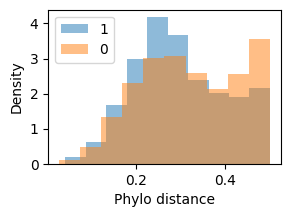

In [426]:
hgt_embed_1 = hgt_embed.loc[hgt_embed.hgt == 1]
hgt_embed_0 = hgt_embed.loc[hgt_embed.hgt == 0]

plt.figure(figsize=(3, 2))
plt.hist(hgt_embed_1.phy_dis, alpha=0.5, density=True, label='1')
plt.hist(hgt_embed_0.phy_dis, alpha=0.5, density=True, label='0')

plt.xlabel("Phylo distance")
plt.ylabel("Density")
plt.legend()  # 显示图例
plt.show()

In [398]:
hgt_embed_keep = hgt_embed.loc[hgt_embed.hgt > 0]
# hgt_embed_keep = hgt_embed_keep.loc[hgt_embed_keep.cosine_co > 0.5]

In [399]:
hgt_embed_keep.shape

(4277, 6)

(array([0.03368538, 0.07176451, 0.4598787 , 1.54659844, 1.81315234,
        1.06035727, 0.61951813, 0.4437683 , 0.18307273, 0.0322208 ]),
 array([-0.61944859, -0.45980662, -0.30016464, -0.14052266,  0.01911932,
         0.1787613 ,  0.33840327,  0.49804525,  0.65768723,  0.81732921,
         0.97697118]),
 <BarContainer object of 10 artists>)

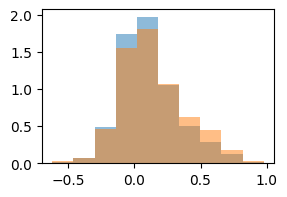

In [400]:
plt.figure(figsize=(3, 2))
plt.hist(hgt_embed.cosine_co, alpha=0.5, density=True)
plt.hist(hgt_embed_keep.cosine_co, alpha=0.5, density=True)

(array([0.12678904, 0.51690917, 1.60924552, 2.51627481, 3.60373466,
        3.44768661, 2.34559726, 2.26757323, 2.11152518, 2.31146175]),
 array([0.02026 , 0.068206, 0.116152, 0.164098, 0.212044, 0.25999 ,
        0.307936, 0.355882, 0.403828, 0.451774, 0.49972 ]),
 <BarContainer object of 10 artists>)

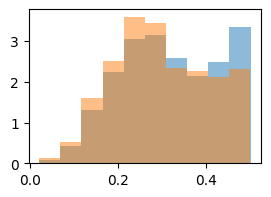

In [401]:
plt.figure(figsize=(3, 2))
plt.hist(hgt_embed.phy_dis, alpha=0.5, density=True)
plt.hist(hgt_embed_keep.phy_dis, alpha=0.5, density=True)

In [402]:
# 初始化逻辑回归模型
model = LogisticRegression(
    # penalty='l2',          # 正则化类型（L2 正则化）
    C=1.0,                # 正则化强度的倒数（越小正则化越强）
    solver='lbfgs',       # 优化算法（适用于小数据集）
    max_iter=1000,        # 最大迭代次数
    random_state=42       # 随机种子
)

In [403]:
all_id = np.unique(list(hgt_embed.id_1.unique()) + list(hgt_embed.id_2.unique()))

In [404]:
# 初始化随机森林分类器
rf_classifier = RandomForestClassifier(
    n_estimators=500,  # 树的数量
    max_depth=None,    # 树的最大深度（不限制）
    random_state=42,    # 随机种子，确保结果可复现
    n_jobs=1
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

(array([0.29922243, 0.91904031, 1.56023122, 2.05181092, 2.60750971,
        2.47927153, 2.39377941, 2.1800491 , 3.54792305, 4.25323305]),
 array([0.05121 , 0.096069, 0.140928, 0.185787, 0.230646, 0.275505,
        0.320364, 0.365223, 0.410082, 0.454941, 0.4998  ]),
 <BarContainer object of 10 artists>)

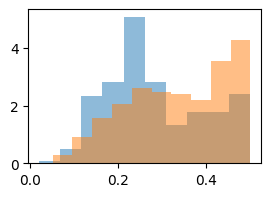

In [405]:
plt.figure(figsize=(3, 2))
plt.hist(hgt_embed_test_keep.phy_dis, alpha=0.5, density=True)
plt.hist(hgt_embed_test_sample.phy_dis, alpha=0.5, density=True)

In [382]:
test = []
group = []
labels = []
proba = []
for fold, (train_index, val_index) in enumerate(kf.split(all_id)):
    
    train_id = all_id[train_index]
    hgt_embed_train = hgt_embed.loc[[i in train_id for i in hgt_embed.id_1.values]]
    hgt_embed_train = hgt_embed_train.loc[[i in train_id for i in hgt_embed_train.id_2.values]]
    
    hgt_embed_test = hgt_embed.loc[[i  not in train_id for i in hgt_embed.id_1.values]]
    hgt_embed_test = hgt_embed_test.loc[[i not in train_id for i in hgt_embed_test.id_2.values]]

    hgt_embed_train_keep = hgt_embed_train.loc[hgt_embed_train.hgt > 0]
    hgt_embed_train_sample = hgt_embed_train.loc[hgt_embed_train.hgt == 0]
    
    phy_dis_list = np.linspace(0, 0.5, 40)
    sample_index = []
    for i in range(1, 20):
        num = hgt_embed_train_keep.loc[(hgt_embed_train_keep.phy_dis.values > phy_dis_list[i-1]) & (hgt_embed_train_keep.phy_dis.values < phy_dis_list[i])].shape[0]
        temp = hgt_embed_train_sample.loc[(hgt_embed_train_sample.phy_dis.values > phy_dis_list[i-1]) & (hgt_embed_train_sample.phy_dis.values < phy_dis_list[i])]
        if temp.shape[0] > num:
            temp = temp.sample(n = num)
        sample_index = sample_index + temp.index.tolist()
    
    hgt_embed_train_sample = hgt_embed_train_sample.loc[sample_index]

    hgt_embed_test_keep = hgt_embed_test.loc[hgt_embed_test.hgt > 0]
    hgt_embed_test_sample = hgt_embed_test.loc[hgt_embed_test.hgt == 0]
    
    sample_index = []
    for i in range(1, 40):
        num = hgt_embed_test_keep.loc[(hgt_embed_test_keep.phy_dis.values > phy_dis_list[i-1]) & (hgt_embed_test_keep.phy_dis.values < phy_dis_list[i])].shape[0]
        temp = hgt_embed_test_sample.loc[(hgt_embed_test_sample.phy_dis.values > phy_dis_list[i-1]) & (hgt_embed_test_sample.phy_dis.values < phy_dis_list[i])]
        if temp.shape[0] > num:
            temp = temp.sample(n = num)
        sample_index = sample_index + temp.index.tolist()
    
    hgt_embed_test_sample = hgt_embed_test_sample.loc[sample_index]

    data = pd.DataFrame({"id_1": hgt_embed_train_keep.id_1.tolist() + hgt_embed_train_sample.id_1.tolist(), 
                     "id_2": hgt_embed_train_keep.id_2.tolist() + hgt_embed_train_sample.id_2.tolist(),
                     "hgt": [1] * hgt_embed_train_keep.shape[0] + [0] * hgt_embed_train_sample.shape[0]})
    X_train = np.hstack((co_embedding.loc[data.id_1.values], co_embedding.loc[data.id_2.values]))
    y_train = data.hgt.values

    data = pd.DataFrame({"id_1": hgt_embed_test_keep.id_1.tolist() + hgt_embed_test_sample.id_1.tolist(), 
                         "id_2": hgt_embed_test_keep.id_2.tolist() + hgt_embed_test_sample.id_2.tolist(),
                         "hgt": [1] * hgt_embed_test_keep.shape[0] + [0] * hgt_embed_test_sample.shape[0]})
    x_test = np.hstack((co_embedding.loc[data.id_1.values], co_embedding.loc[data.id_2.values]))
    y_test = data.hgt.values

    # 训练模型
    rf_classifier.fit(X_train, y_train)
    # 对测试集进行预测
    y_pred_proba = rf_classifier.predict_proba(x_test)
    auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
    
    test = test + [f"test_{fold}"] * len(y_test)
    group = group + ["SNE"] * len(y_test)
    labels = labels + list(y_test)
    proba = proba + list(y_pred_proba[:,1])
    
    print(f"test_{fold} AUC 值: {auc_score:.4f}")


    ### LG
    data = pd.DataFrame({"id_1": hgt_embed_train_keep.id_1.tolist() + hgt_embed_train_sample.id_1.tolist(), 
                     "id_2": hgt_embed_train_keep.id_2.tolist() + hgt_embed_train_sample.id_2.tolist(),
                     "hgt": [1] * hgt_embed_train_keep.shape[0] + [0] * hgt_embed_train_sample.shape[0]})
    X_train = np.hstack((phy_embedding.loc[data.id_1.values], phy_embedding.loc[data.id_2.values]))
    y_train = data.hgt.values

    data = pd.DataFrame({"id_1": hgt_embed_test_keep.id_1.tolist() + hgt_embed_test_sample.id_1.tolist(), 
                     "id_2": hgt_embed_test_keep.id_2.tolist() + hgt_embed_test_sample.id_2.tolist(),
                     "hgt": [1] * hgt_embed_test_keep.shape[0] + [0] * hgt_embed_test_sample.shape[0]})
    x_test = np.hstack((phy_embedding.loc[data.id_1.values], phy_embedding.loc[data.id_2.values]))
    y_test = data.hgt.values

    # 训练模型
    rf_classifier.fit(X_train, y_train)
    # 对测试集进行预测
    y_pred_proba = rf_classifier.predict_proba(x_test)
    auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
    print(f"AUC_{fold} 值: {auc_score:.4f}")

    test = test + [f"test_{fold}"] * len(y_test)
    group = group + ["PhyloE"] * len(y_test)
    labels = labels + list(y_test)
    proba = proba + list(y_pred_proba[:,1])

test_0 AUC 值: 0.8345
AUC_0 值: 0.7354
test_1 AUC 值: 0.7918
AUC_1 值: 0.6180
test_2 AUC 值: 0.6706
AUC_2 值: 0.7200
test_3 AUC 值: 0.6953
AUC_3 值: 0.6898
test_4 AUC 值: 0.7710
AUC_4 值: 0.6896


In [ ]:
hgt_predict_res = pd.DataFrame({"test":test, "group":group, "labels":labels, "proba":proba})
hgt_predict_res.to_csv("/home/dongbiao/word_embedding_microbiome/HGT/results/hgt_predict_res.csv", index=None)

In [406]:
test = []
group = []
labels = []
proba = []
for fold, (train_index, val_index) in enumerate(kf.split(all_id)):
    
    train_id = all_id[train_index]
    hgt_embed_train = hgt_embed.loc[[i in train_id for i in hgt_embed.id_1.values]]
    hgt_embed_train = hgt_embed_train.loc[[i in train_id for i in hgt_embed_train.id_2.values]]
    
    hgt_embed_test = hgt_embed.loc[[i  not in train_id for i in hgt_embed.id_1.values]]
    hgt_embed_test = hgt_embed_test.loc[[i not in train_id for i in hgt_embed_test.id_2.values]]

    hgt_embed_train_keep = hgt_embed_train.loc[hgt_embed_train.hgt > 0]
    hgt_embed_train_sample = hgt_embed_train.loc[hgt_embed_train.hgt == 0]

    hgt_embed_test_keep = hgt_embed_test.loc[hgt_embed_test.hgt > 0]
    hgt_embed_test_sample = hgt_embed_test.loc[hgt_embed_test.hgt == 0]

    data = pd.DataFrame({"id_1": hgt_embed_train_keep.id_1.tolist() + hgt_embed_train_sample.id_1.tolist(), 
                         "id_2": hgt_embed_train_keep.id_2.tolist() + hgt_embed_train_sample.id_2.tolist(),
                         "hgt": [1] * hgt_embed_train_keep.shape[0] + [0] * hgt_embed_train_sample.shape[0]})
    X_train = np.hstack((co_embedding.loc[data.id_1.values], co_embedding.loc[data.id_2.values]))
    y_train = data.hgt.values

    data = pd.DataFrame({"id_1": hgt_embed_test_keep.id_1.tolist() + hgt_embed_test_sample.id_1.tolist(), 
                         "id_2": hgt_embed_test_keep.id_2.tolist() + hgt_embed_test_sample.id_2.tolist(),
                         "hgt": [1] * hgt_embed_test_keep.shape[0] + [0] * hgt_embed_test_sample.shape[0]})
    x_test = np.hstack((co_embedding.loc[data.id_1.values], co_embedding.loc[data.id_2.values]))
    y_test = data.hgt.values

    # 训练模型
    rf_classifier.fit(X_train, y_train)
    # 对测试集进行预测
    y_pred_proba = rf_classifier.predict_proba(x_test)
    auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
    
    test = test + [f"test_{fold}"] * len(y_test)
    group = group + ["SNE"] * len(y_test)
    labels = labels + list(y_test)
    proba = proba + list(y_pred_proba[:,1])
    
    print(f"test_{fold} AUC 值: {auc_score:.4f}")


    data = pd.DataFrame({"id_1": hgt_embed_train_keep.id_1.tolist() + hgt_embed_train_sample.id_1.tolist(), 
                     "id_2": hgt_embed_train_keep.id_2.tolist() + hgt_embed_train_sample.id_2.tolist(),
                     "hgt": [1] * hgt_embed_train_keep.shape[0] + [0] * hgt_embed_train_sample.shape[0]})
    X_train = np.hstack((phy_embedding.loc[data.id_1.values], phy_embedding.loc[data.id_2.values]))
    y_train = data.hgt.values

    data = pd.DataFrame({"id_1": hgt_embed_test_keep.id_1.tolist() + hgt_embed_test_sample.id_1.tolist(), 
                     "id_2": hgt_embed_test_keep.id_2.tolist() + hgt_embed_test_sample.id_2.tolist(),
                     "hgt": [1] * hgt_embed_test_keep.shape[0] + [0] * hgt_embed_test_sample.shape[0]})
    x_test = np.hstack((phy_embedding.loc[data.id_1.values], phy_embedding.loc[data.id_2.values]))
    y_test = data.hgt.values

    # 训练模型
    rf_classifier.fit(X_train, y_train) 
    # 对测试集进行预测
    y_pred_proba = rf_classifier.predict_proba(x_test)
    auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
    print(f"AUC_{fold} 值: {auc_score:.4f}")

    test = test + [f"test_{fold}"] * len(y_test)
    group = group + ["PhyloE"] * len(y_test)
    labels = labels + list(y_test)
    proba = proba + list(y_pred_proba[:,1])

test_0 AUC 值: 0.7743
AUC_0 值: 0.7575
test_1 AUC 值: 0.7128
AUC_1 值: 0.6592
test_2 AUC 值: 0.7292
AUC_2 值: 0.7019
test_3 AUC 值: 0.7590
AUC_3 值: 0.7799
test_4 AUC 值: 0.7858
AUC_4 值: 0.7336


In [407]:
hgt_predict_res = pd.DataFrame({"test":test, "group":group, "labels":labels, "proba":proba})
hgt_predict_res.to_csv("/home/dongbiao/word_embedding_microbiome/HGT/results/hgt_predict_res_keep_phy.csv", index=None)